# Parte 1: Análisis y Visualización

Durante la primera etapa se busca familiarizarse con el conjunto de datos (dataset) y aprender a administrar/trabajar con datos en formato json. Luego de unificar los datos en un único dataset, se analizarán los mismos, tanto en cantidad y como en calidad. Se indagará no sólo el tipo de cada dato sino su naturaleza, su evolución y agrupación temporal principalmente.

Se utilizarán visualizaciones y herramientas estadísticas para facilitar encontrar correlación entre las variables. Los gráficos de las distribuciones de los datos, los estadísticos necesarios utilizados para caracterizar las distintas variables e identificar los valores atípicos (outliers) o datos faltantes serán el resultado de estos análisis.

Por último, se identificará la variable objetivo (target) que será aquella a predecir.

## Configuración del entorno

Primero se importan las liberias y modulos necesarios para hacer un analisis de los distintos gráficos del dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter


In [2]:
!python --version
pd.__version__, sns.__version__, np.__version__

Python 3.10.12


('2.0.3', '0.13.1', '1.25.2')

Se crea un dataframe a partir de los datos en formato `.csv`

In [3]:
#url = 'https://raw.githubusercontent.com/gaston-nieto/grupo2-mentoria12/main/output.csv?token=GHSAT0AAAAAACPIKXLFAW6AOFNBTG4NWEFSZUBX3EA'

In [4]:
df = pd.read_csv('output.csv')

In [5]:
df.head()

,fecha,vehículos,diaSemana,turno,periodo,IntervaloSegmento
0,01/08/2023,339.0,Martes,NOCHE,2023/08,De 21:15 hs. a 21:30 hs.
1,02/08/2023,356.0,Miércoles,NOCHE,2023/08,De 21:15 hs. a 21:30 hs.
2,03/08/2023,352.0,Jueves,NOCHE,2023/08,De 21:15 hs. a 21:30 hs.
3,04/08/2023,416.0,Viernes,NOCHE,2023/08,De 21:15 hs. a 21:30 hs.
4,05/08/2023,455.0,Sábado,NOCHE,2023/08,De 21:15 hs. a 21:30 hs.


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160701 entries, 0 to 160700
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fecha              160699 non-null  object 
 1   vehículos          160699 non-null  float64
 2   diaSemana          160699 non-null  object 
 3   turno              160699 non-null  object 
 4   periodo            160699 non-null  object 
 5   IntervaloSegmento  160701 non-null  object 
dtypes: float64(1), object(5)
memory usage: 7.4+ MB


El dataset tiene 6 columnas:
- fecha: fecha compuesta por día, mes y año, tipo `object`
- vehículos: cantidad de vehiculos medidos, tipo `float`
- diaSemana: día de la semana
- turno: turno donde se midio la cantidad de vehículos (puede ser madrugada, mañana, tarde, siesta o noche)
- periodo: año y mes
- IntervaloSegmento: es el intervalo de tiempo donde se realizo la medicion, generalmente de 15 minutos, tipo `object`

## Preparación del Dataset



A partir de esto se van a hacer los siguiente cambios:
- Eliminar todas las tildes: vehículos, miércoles y sábado
- Convertir a tipo `datetime` la columna fecha
- Extraer de IntervaloSegmento la hora y minutos en la que se termino de medir
- Ordenar los días de semana a partir del lunes
- Ordenar los turnos
- Convertir todos los datos a minúsculas

Las siguiente celdas realizan los cambios mencionados

In [7]:
df.rename(columns={'vehículos': 'vehiculos'}, inplace=True)

df['diaSemana'] = df['diaSemana'].replace(['Miércoles', 'Sábado'],
                                          ['Miercoles', 'Sabado'])

df['fecha'] = pd.to_datetime(df.fecha, format='%d/%m/%Y')

df['hora'] = df['IntervaloSegmento'].apply(
    lambda intervalo: intervalo.split(' a ')[1].split(' hs.')[0])

dias_ordenados = [
    'Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo']
turnos_ordenados = [
    'MADRUGADA', 'MAÑANA', 'TARDE', 'SIESTA', 'NOCHE']

df['diaSemana'] = pd.Categorical(df['diaSemana'],
                                 categories=dias_ordenados,
                                 ordered=True)

df['turno'] = pd.Categorical(df['turno'],
                             categories=turnos_ordenados,
                             ordered=True)

df.sample(5)

,fecha,vehiculos,diaSemana,turno,periodo,IntervaloSegmento,hora
31321,2019-08-24,395.0,Sabado,MAÑANA,2019/08,De 09:30 hs. a 09:45 hs.,09:45
81390,2022-07-17,74.0,Domingo,TARDE,2022/07,De 20:15 hs. a 20:30 hs.,20:30
70652,2023-01-03,30.0,Martes,MADRUGADA,2023/01,De 04:15 hs. a 04:30 hs.,04:30
53506,2019-10-19,219.0,Sabado,MADRUGADA,2019/10,De 04:45 hs. a 05:00 hs.,05:00
20899,2021-03-25,191.0,Jueves,TARDE,2021/03,De 20:15 hs. a 20:30 hs.,20:30


Se podria unir las columnas fecha y hora para tener una sola columna con el formato `datetime` pero para un primer análisis no va a ser necesario

### Funciones

Se crearon funciones para poder generar más fácil los gráficos correspondientes. Mediante `seaborn`se hicieron los distintos tipo de gráficos. Una función muy útil es `.pivot_table` que permite crear una nueva tabla a partir de un dataframe, seleccionando el índice y columnas

In [8]:
def lineplot_dia(df):
    plt.figure(figsize=(12, 15))
    for i, year in enumerate(range(2019, 2025)):
        plt.subplot(6, 2, i + 1)

        sns.lineplot(
            data=df[df['fecha'].dt.year == year],
            x=df['fecha'].dt.dayofyear,
            y='vehiculos',
            errorbar=None
        )
        plt.grid(alpha=0.5)
        plt.ylim(0, 400)
        plt.xlim(1, 366)
        plt.xlabel('Día')
        plt.ylabel('Vehículos')
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.title(f'Cantidad de vehículos por día - {year}', fontsize=10)

    plt.tight_layout()
    plt.show()

In [9]:
def barplot_mes(df):
    plt.figure(figsize=(12, 15))

    for i, year in enumerate(range(2019, 2025)):
        plt.subplot(6, 2, i + 1)
        df_aux = df[df['fecha'].dt.year == year]
        sns.barplot(
            x=df_aux['fecha'].dt.month,
            y='vehiculos',
            data=df_aux,
            errorbar=None, hue=df_aux['fecha'].dt.month, palette='tab20c', legend=False)

        plt.xticks(ticks=range(12), labels=['Enero', 'Febrero', 'Marzo',
                                            'Abril', 'Mayo', 'Junio',
                                            'Julio', 'Agosto', 'Septiembre',
                                            'Octubre', 'Noviembre', 'Diciembre'],
                    rotation=45)
        plt.grid(axis='y', alpha=0.5)
        plt.ylim(0, 350)
        plt.xlabel('Mes')
        plt.ylabel('Vehículos')
        plt.title(f'Cantidad de vehículos por mes - {year}', fontsize=10)

    plt.tight_layout()
    plt.show()

In [10]:
def lineplot_dataset(df):
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df.groupby('fecha')['vehiculos'].sum())
    plt.grid(alpha=0.5)
    plt.xlabel('Día')
    plt.ylabel('Vehículos')
    plt.title('Cantidad de vehículos', fontsize=10)
    plt.tight_layout()
    plt.show()

In [11]:
def heatmap_dataset(df):
    df_aux = df.pivot_table(index='diaSemana', columns='hora', values='vehiculos', aggfunc='mean')
    plt.figure(figsize=(12, 3))
    sns.heatmap(df_aux, cmap='coolwarm', square=False, cbar=False)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.ylabel(' ')
    plt.xlabel(' ')
    plt.title('Cantidad de vehículos por día y hora', fontsize=10)
    plt.tight_layout()
    plt.show()

In [12]:
def heatmap_turno(df):
    plt.figure(figsize=(12, 15))

    for i, year in enumerate(range(2019, 2025)):
        plt.subplot(6, 2, i + 1)

        df_aux = df[df['fecha'].dt.year == year].pivot_table(index='diaSemana', columns='turno', values='vehiculos', aggfunc='sum')
        sns.heatmap(df_aux, cmap='coolwarm', annot=True, fmt='.2f', cbar=False, annot_kws={'size': 8})

        plt.title(f'Cantidad de vehículos por turno - {year}', fontsize=10)
        plt.xticks(fontsize=8)
        plt.yticks(rotation=0, fontsize=8)
        plt.xlabel(' ')
        plt.ylabel(' ')

    plt.tight_layout()
    plt.show()

In [13]:
def heatmap_dia(df):
    plt.figure(figsize=(12, 15))

    for i, year in enumerate(range(2019, 2025)):
        plt.subplot(6, 2, i + 1)
        df_year = df[df['fecha'].dt.year == year]
        df_aux_4 = df_year.pivot_table(index=df_year['fecha'].dt.month, columns=df_year['fecha'].dt.day, values='vehiculos', aggfunc='sum')

        sns.heatmap(df_aux_4, cmap='coolwarm', square=True, cbar_kws={"shrink": 0.62}, cbar=False)

        plt.xticks(rotation=0, fontsize=6)
        plt.yticks(rotation=0, fontsize=6)
        plt.xlabel('Día')
        plt.ylabel('Mes')
        plt.title(f'Cantidad de vehículos por día y mes - {year}', fontsize=10)
    plt.tight_layout()
    plt.show()

In [14]:
def boxplot_mes(df):
    plt.figure(figsize=(12, 16))

    for i, year in enumerate(range(2019, 2025)):
        plt.subplot(6, 2, i + 1)

        df_aux = df[df['fecha'].dt.year == year]
        sns.boxplot(data=df_aux, x=df_aux.fecha.dt.month, y='vehiculos', hue=df_aux.fecha.dt.month, palette='tab20c', legend=False)

        plt.ylim(-50, 800)
        plt.title(f'Cantidad de vehículos por mes - {year}', fontsize=10)
        plt.xticks(ticks=range(12), labels=['Enero', 'Febrero', 'Marzo',
                                            'Abril', 'Mayo', 'Junio',
                                            'Julio', 'Agosto', 'Septiembre',
                                            'Octubre', 'Noviembre', 'Diciembre'],
                    rotation=45)
        plt.yticks(rotation=0, fontsize=8)
        plt.xlabel(' ')
        plt.ylabel(' ')

    plt.tight_layout()
    plt.show()

In [15]:
def contador_vehiculos_nulos(df):
    plt.figure(figsize=(12, 15))

    for i, year in enumerate(range(2019, 2025)):
        plt.subplot(6, 2, i + 1)
        df_aux = df[df['fecha'].dt.year == year]
        sns.lineplot(df_aux[df_aux['vehiculos'] == 0]['fecha'].value_counts())

        plt.grid(axis='y', alpha=0.5)
        plt.ylim(0, 100)
        plt.xticks(rotation=90)
        plt.xlabel('Mes')
        plt.ylabel(' ')
        plt.title(f'Cantidad de valores nulos - {year}', fontsize=10)

    plt.tight_layout()

## Gráficos

### Cantidad de vehículos por día

Se plantea un grafico `.lineplot` donde se muestra la cantidad de vehiculos de todo el dataset, es decir, desde fines del 2019 a principios del 2024

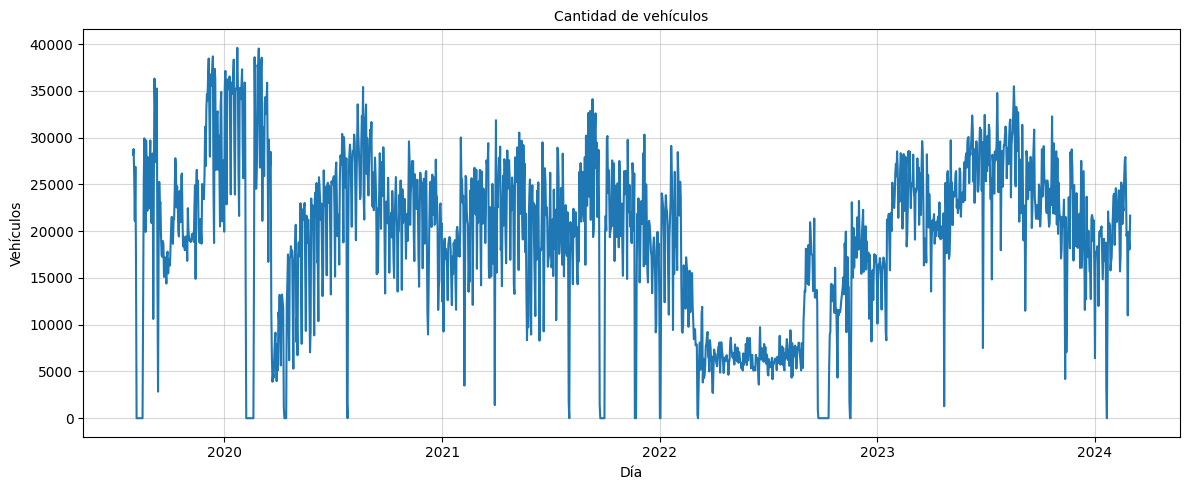

In [16]:
lineplot_dataset(df)

Se realiza el mismo gráfico pero separados por año

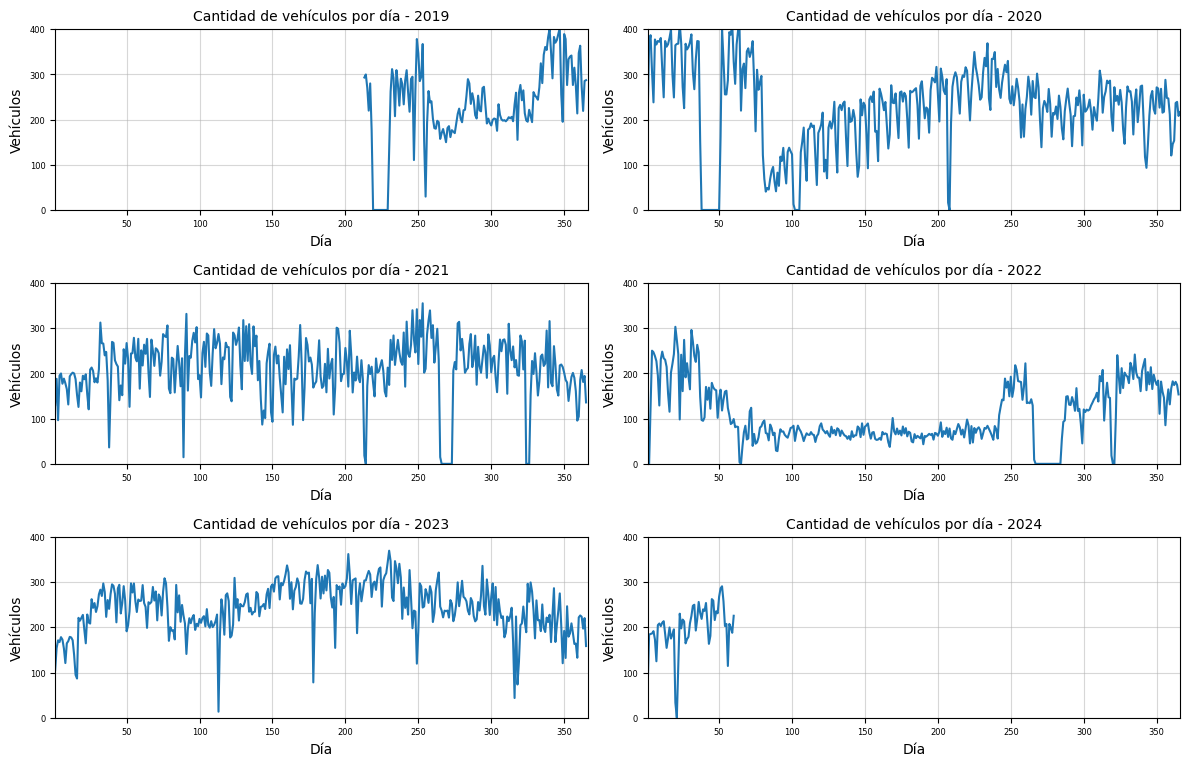

In [17]:
lineplot_dia(df)

Se observa lo siguiente:
- Periodos con 0 vehículos
- Gran descenso y lento recupero de la cantidad de vehículos en el año 2020
- Descenso en el flujo vehicular correspondiente a los fines de semana
- Descenso en gran parte del año 2022 correspondiente con las [obras realizadas](https://cordoba.gob.ar/chacabuco-maipu-comenzo-la-construccion-del-cantero-central/)

### Cantidad de vehículos por mes

Se plantea un grñafico tipo `.barplot` agrupado por mes.

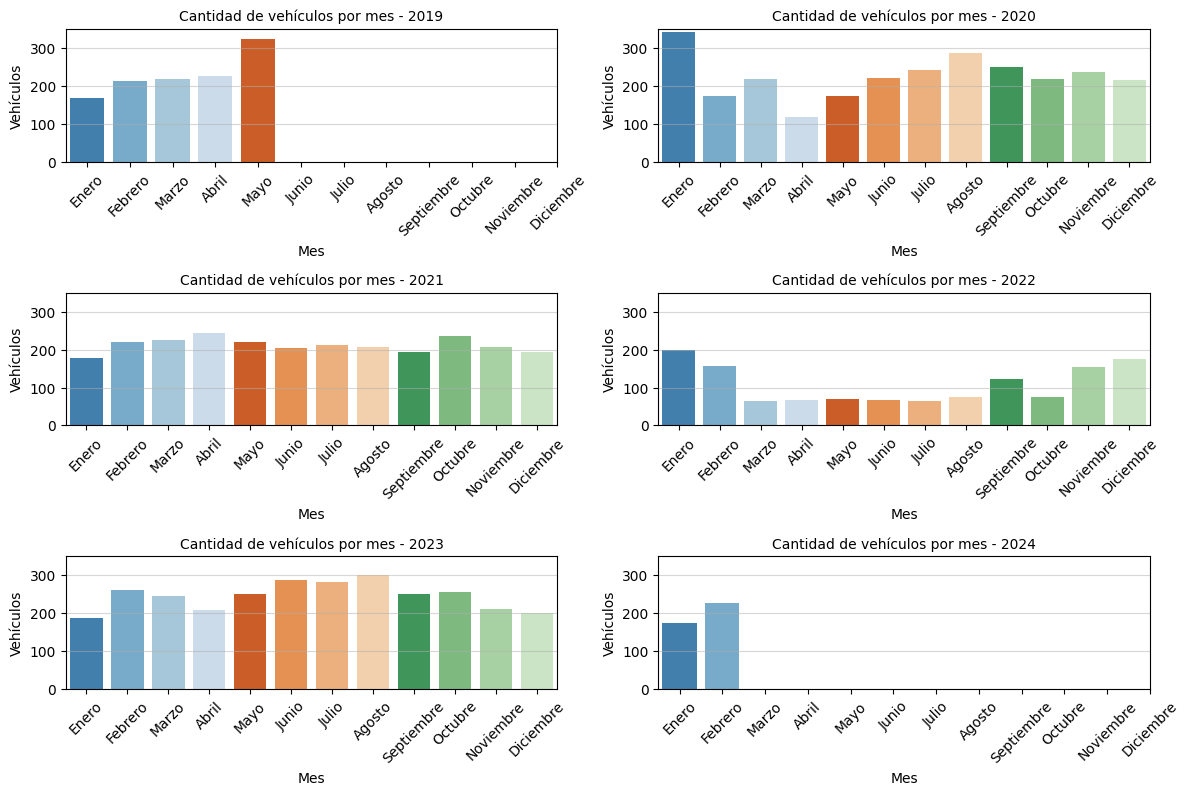

In [18]:
barplot_mes(df)

Se puede observar que cada cuatrimestre esta bien delimitado, teniendo altas y bajas en el flujo vehicular

### Mapas de calor

Mediante los mapas de calor se puede observar que día y hora son los más transitados

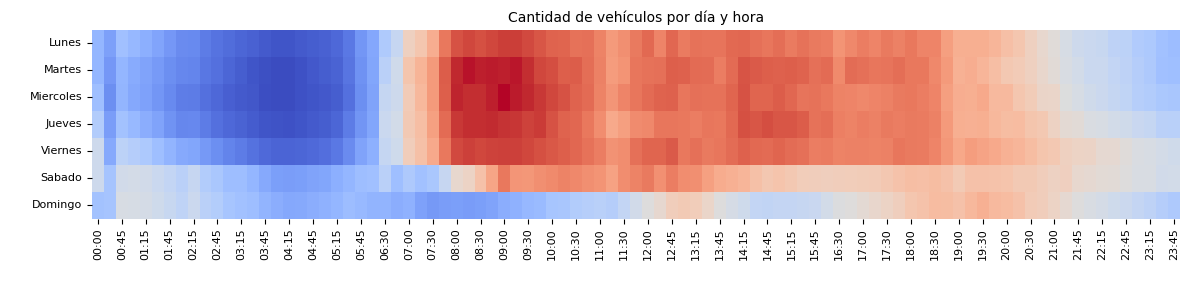

In [19]:
heatmap_dataset(df)

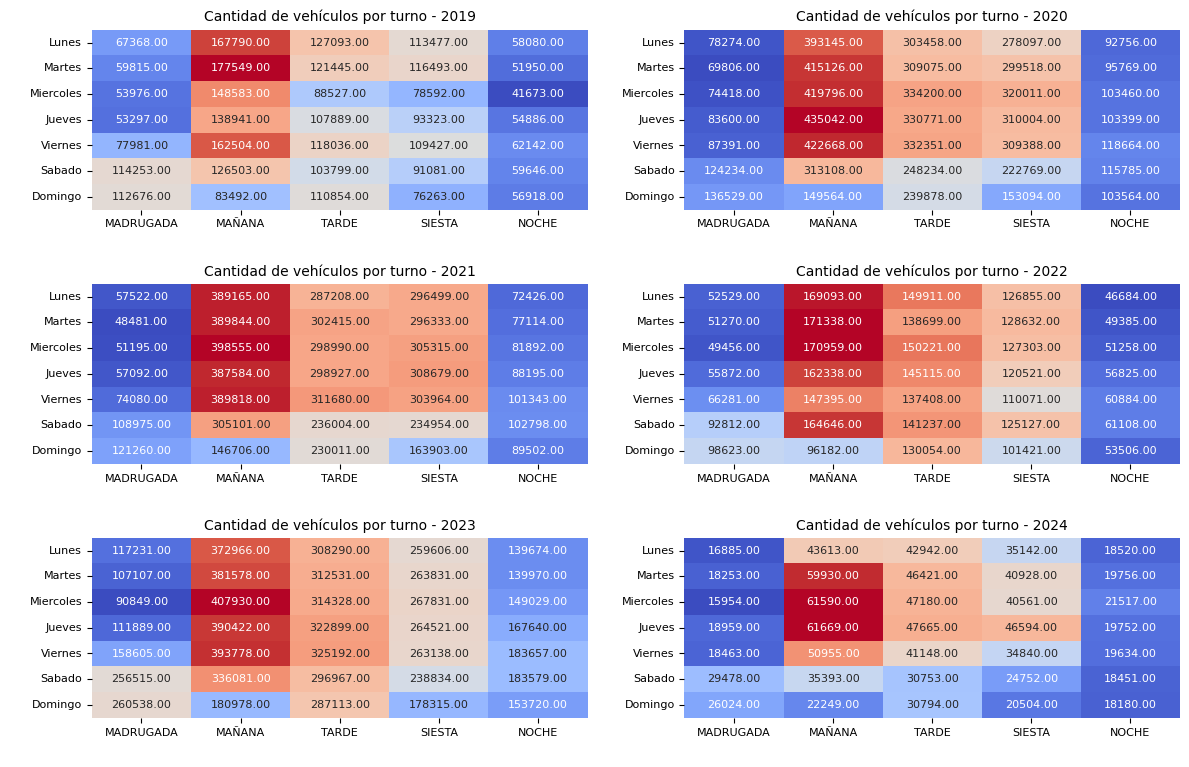

In [20]:
heatmap_turno(df)

Se observa lo siguiente:
- Los días de semana por la mañana son los más transitados
- Tambien, los días de seemana pero por la madrugada son los menos transitados
- Luego de las 20h es transito baja considerablemente
- El día domingo es el menos transitado pero se observa más transito cerca del mediodia

Se puede hacer un mapa de calor más detallado, por día y mes

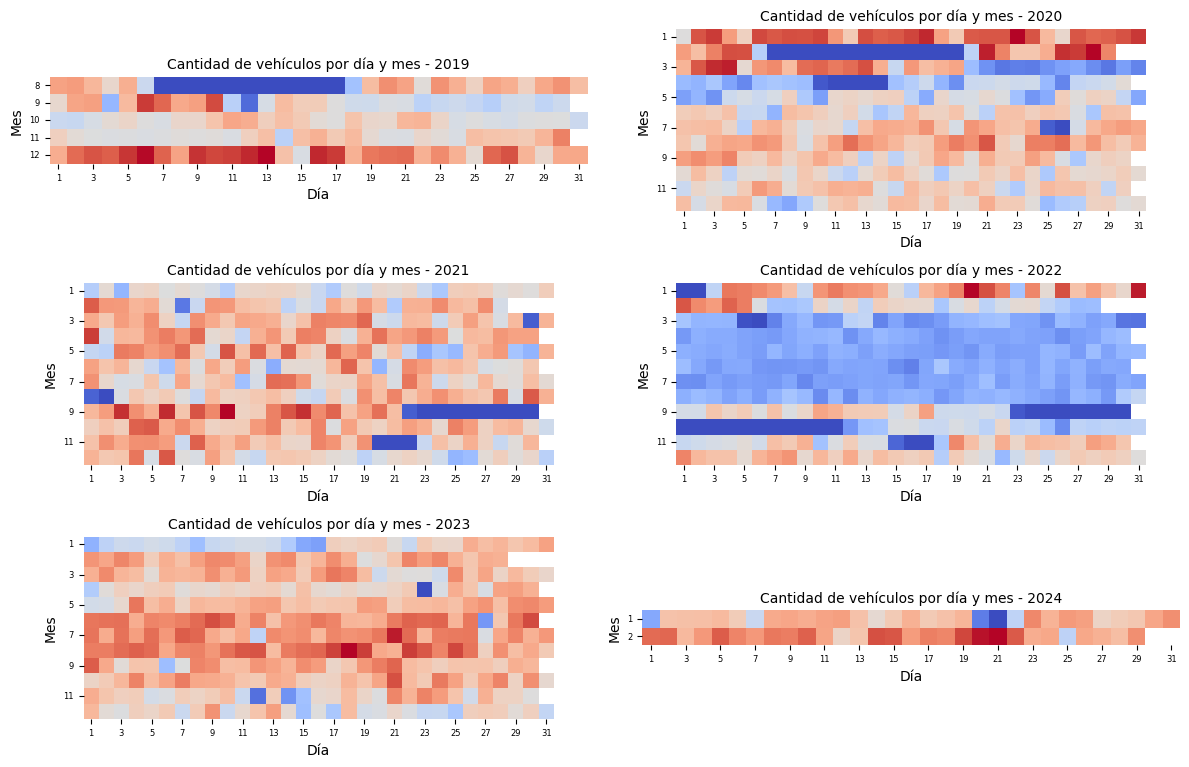

In [21]:
heatmap_dia(df)

Se puede observar:
- Muy poco transito vehicular en navidad, año nuevo y 18/12 correspondiente a la final del mundo
- Días donde no se registro ningun vehiculo

### Boxplot por mes

Finalmente se grafico los `.boxplot` correspondientes a cada mes

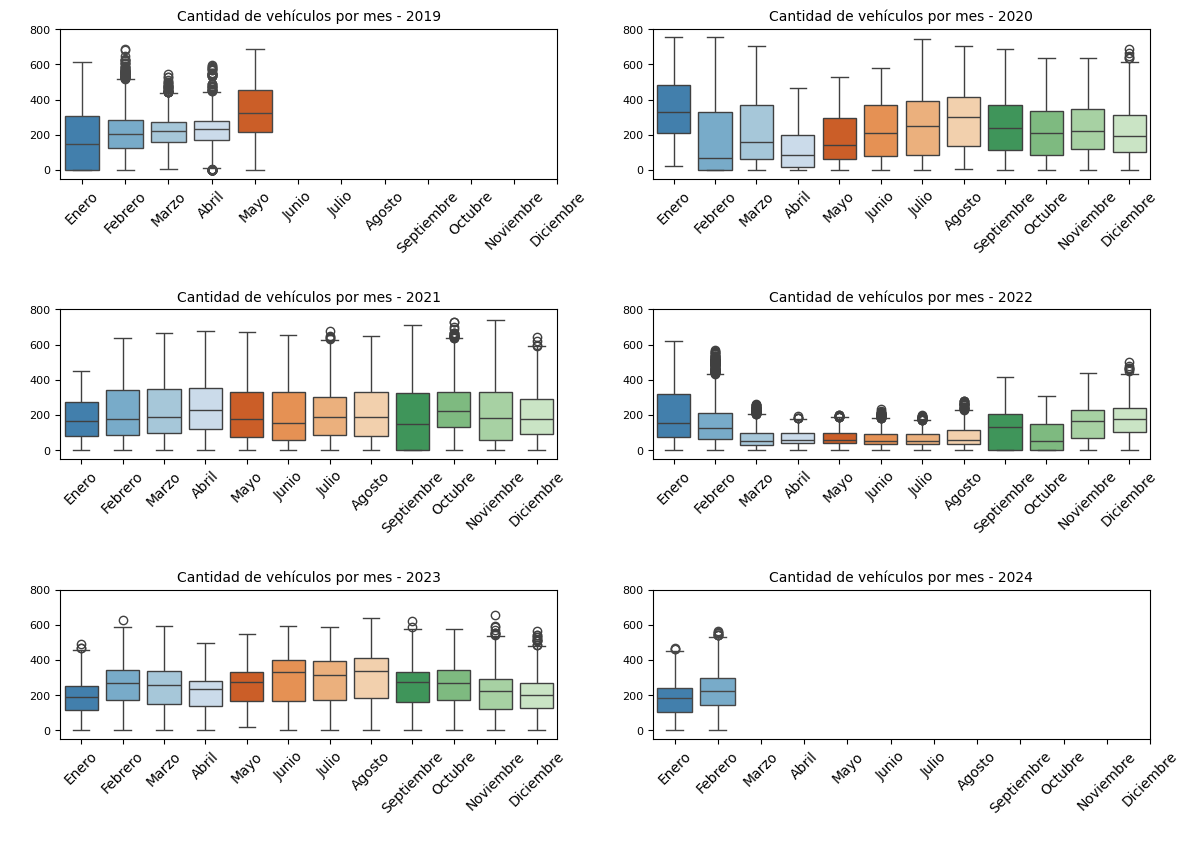

In [22]:
boxplot_mes(df)

Se puede observar una media bastante equilibrada, aunque nuevamente en abril del 2020 y durante varios meses del 2022 una baja considerable

### Valores nulos

Como la variable objetivo para este caso es `vehiculos`, es necesario saber donde estan dichos valores. Estos se pueden generar por un error de la medición o por una medición verdadera

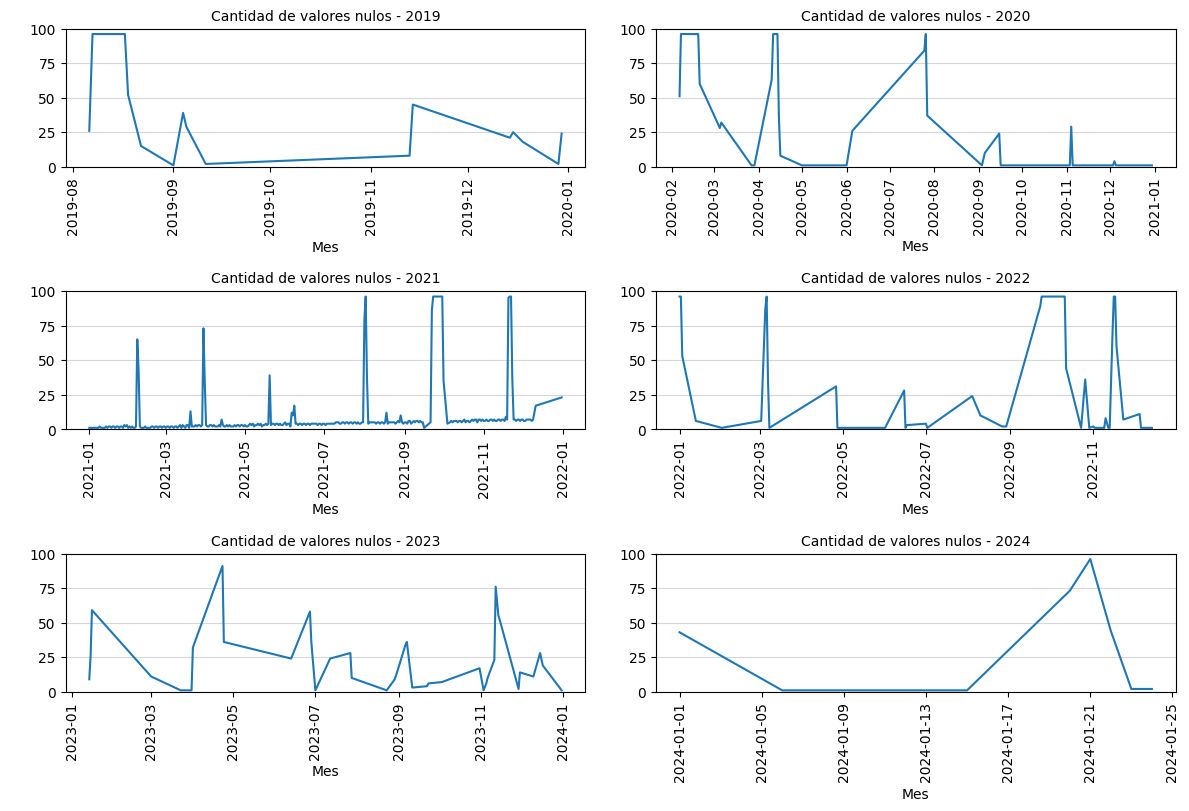

In [23]:
contador_vehiculos_nulos(df)

Hay que tener en cuenta que cada día tiene aproximadamente 16 mediciones, repartidas por hora y turno

In [24]:
print('Cantidad de filas con vehiculo nulos:', df[df['vehiculos'] == 0].value_counts().sum())

Cantidad de filas con vehiculo nulos: 10557
